# Independent Component Analysis
---
Author: quangtiencs
<br>Blog: https://thetalog.com/statistics/independent-component-analysis/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
from sklearn.decomposition import PCA
from matplotlib import style

style.use('bmh')
np.random.seed(0)

In [2]:
n_samples = 400
time = np.linspace(0, 10, n_samples)

s1 = 2.2*np.sin(2 * time)
s2 = 0.8*np.sign(np.sin(3 * time))
s3 = 1.5*signal.sawtooth(2 * np.pi * time)

noise1 = 1.5*np.random.normal(loc=0.0, scale=0.04, size=n_samples)
noise2 = 0.7*np.random.normal(loc=0.0, scale=0.04, size=n_samples)
noise3 = 2.1*np.random.normal(loc=0.0, scale=0.04, size=n_samples)

S = np.c_[s1+noise1, s2+noise2, s3+noise3]

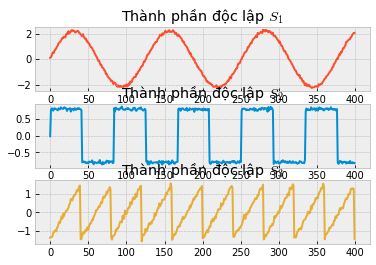

In [3]:
plt.figure()

fig = plt.subplot(3, 1, 1)
fig.set_title("Thành phần độc lập $S_1$")
plt.plot(S[:, 0], color="#fc4f30")

fig = plt.subplot(3, 1, 2)
fig.set_title("Thành phần độc lập $S_2$")
plt.plot(S[:, 1], color="#008fd5")

fig = plt.subplot(3, 1, 3)
fig.set_title("Thành phần độc lập $S_3$")
plt.plot(S[:, 2], color="#e5ae38")

plt.show()

In [4]:
# Ma trận bên dưới không quan sát được
A = np.array([[1, 1.2, 0.8], 
              [0.5, 2, 1.0], 
              [1.5, 1.0, 2.0]])
# Tạo dữ liệu
X = S @ A.T

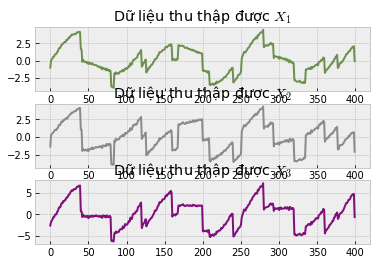

In [5]:
#axes.prop_cycle: cycler('color', ['008fd5', 'fc4f30', 'e5ae38', '6d904f', '8b8b8b', '810f7c'])
fig = plt.subplot(3, 1, 1)
fig.set_title("Dữ liệu thu thập được $X_1$")
plt.plot(X[:,0], color="#6d904f")

fig = plt.subplot(3, 1, 2)
fig.set_title("Dữ liệu thu thập được $X_2$")
plt.plot(X[:,1], color="#8b8b8b")

fig = plt.subplot(3, 1, 3)
fig.set_title("Dữ liệu thu thập được $X_3$")
plt.plot(X[:,2], color="#810f7c")

plt.show()

In [6]:
#np.savetxt("X.csv", X, delimiter=",")

In [7]:
#np.savetxt("S-true.csv", S, delimiter=",")

In [8]:
def center_data(X):
    """Chỉnh tâm dữ liệu
    
    :param X: np.array - n dòng với p cột
    
    :return X_new: numpy.array - X sau khi được chỉnh tâm trừ cho trung bình
    """
    X_mean = X.mean(axis = 0)
    X_new = X - X_mean
    return X_new

In [9]:
def whiten_data(X):
    """Tẩy dữ liệu
    
    :param X: np.array - n dòng với p cột
    
    :return X_whiten: numpy.array - dữ liệu sau khi được whitening transformation
    """
    # sử dụng PCA để whitening
    pca = PCA(X.shape[1], whiten=True)
    X_whiten = pca.fit_transform(X)
    return X_whiten

In [10]:
X = center_data(X)

In [11]:
X = whiten_data(X)

In [12]:
def logcosh(y, alpha=1.0):
    """Hàm logcosh

    G(y) = 1/alpha * log(cosh(alpha y))
    g(y) = tanh(alpha * y)
    g'(y) = alpha ( 1 - tanh^2(alpha * y))

    :param y: np.array - p dòng với n cột

    :return gy: g(y) - shape (p, n)
    :return g_y: g'(y) - shape (p, )
    """
    y = alpha * y
    gy = np.tanh(y)
    g_y = alpha * (1 - gy*gy)
    return gy, g_y


def exp(y):
    """Hàm exp

    G(y) = -exp[(-y^2) / 2]
    g(y) = y exp[(-y^2) / 2]
    g'(y) = (1-y^2) exp[(-y^2) / 2]

    :param y: np.array - p dòng với n cột

    :return gy: g(y) - shape (p, n)
    :return g_y: g'(y) - shape (p, )
    """
    exp = np.exp(-(y ** 2) / 2)
    gy = y * exp
    g_y = (1 - y ** 2) * exp
    return gy, g_y

In [13]:
def fastica_oneunit(X, g_func=logcosh, tolerance=1e-5, max_iter=1000):
    """ FastICA cho một thành phần độc lập
    (tính toán vectorize)

    :param X: np.array - n dòng với p cột
    :param g_func: function - hàm trả về g & g'
    :param tolerance: float - dung sai cho phép
    :param max_iter: số vòng lặp tối đa

    :return w: np.array - shape (1, p)
    """
    # m: số lượng mẫu, p: số lượng chiều
    m = X.shape[0]
    p = X.shape[1]

    # tạo ngẫu nhiên vector w
    w = np.random.normal(size=(1, p))

    for i in range(max_iter):
        wtx = w @ X.T
        gwtx, g_wtx = g_func(wtx)

        w_new = gwtx @ X / float(m) - g_wtx.mean(axis=1) * w
        w_new = w_new / np.linalg.norm(w_new)

        epsilon = np.linalg.norm(w_new @ w.T - 1)

        w = w_new

        if epsilon < tolerance:
            break
    return w

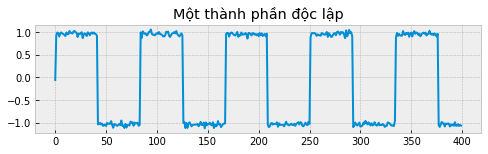

In [14]:
np.random.seed(12)

# Chạy FastICA cho một thành phần
w = fastica_oneunit(X)

estimate_s = w @ X.T
estimate_s = estimate_s.T

#Vẽ nào
plt.figure(figsize=(8,2))

plt.title("Một thành phần độc lập")
plt.plot(estimate_s, color="#008fd5")
plt.show()

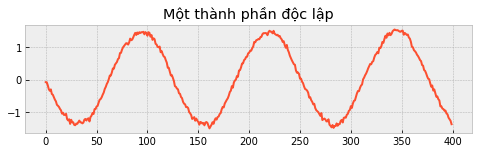

In [15]:
np.random.seed(50)

# Chạy FastICA cho một thành phần
w = fastica_oneunit(X)

estimate_s = w @ X.T
estimate_s = estimate_s.T

#Vẽ nào
plt.figure(figsize=(8,2))

plt.title("Một thành phần độc lập")
plt.plot(estimate_s, color="#fc4f30")
plt.show()

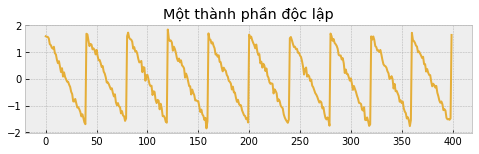

In [16]:
np.random.seed(51)

# Chạy FastICA cho một thành phần
w = fastica_oneunit(X)

estimate_s = w @ X.T
estimate_s = estimate_s.T

#Vẽ nào
plt.figure(figsize=(8,2))

plt.title("Một thành phần độc lập")
plt.plot(estimate_s, color="#e5ae38")
plt.show()

In [17]:
def symetric_orthogonalization(W):
    """ Trực giao hóa đối xứng (xóa tương quan)

    :param W: np.array - p dòng với p cột
    :return W: np.array - p dòng với p cột
    """
    eigen_val, eigen_vec = np.linalg.eigh(np.dot(W, W.T))
    sqrt_wwt = (eigen_vec * (1. / np.sqrt(eigen_val))) @ eigen_vec.T
    return sqrt_wwt @ W


def fastica_symetric(X, g_func=logcosh, tolerance=1e-04, max_iter=1000):
    """ FastICA cho nhiều thành phần
    Parallel FastICA - dùng trực giao đối xứng

    :param X: np.array - n dòng với p cột
    :param g_func: function - hàm trả về g & g'
    :param tolerance: float - dung sai cho phép
    :param max_iter: số vòng lặp tối đa

    :return W: np.array - shape (p, p) với mỗi hàng là w_i
    """
    m = float(X.shape[0])
    p = X.shape[1]

    # Tạo ngẫu nhiên
    W = np.asarray(np.random.normal(size=(p, p)))

    # Trực giao hóa
    W = symetric_orthogonalization(W)

    for i in range(max_iter):
        wxt = W @ X.T
        gwtx, g_wtx = g_func(wxt)

        W_new = (gwtx @ X) / float(m) - g_wtx.mean(axis=1).reshape(p, 1) * W
        W_new = symetric_orthogonalization(W_new)

        epsilon = float(np.max(np.abs(np.abs(np.diag(W_new @ W.T)) - 1)))

        W = W_new

        if epsilon < tolerance:
            break

    return W

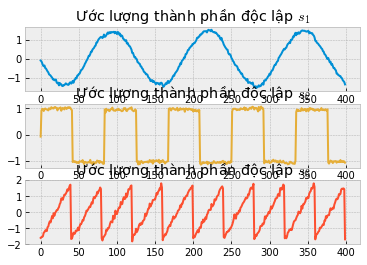

In [18]:
W = fastica_symetric(X)

estimate_S = W @ X.T
estimate_S = estimate_S.T

# Vẽ nào
plt.figure()

fig = plt.subplot(3, 1, 1)
fig.set_title("Ước lượng thành phần độc lập $s_1$")
plt.plot(estimate_S[:,0], color="#008fd5")

fig = plt.subplot(3, 1, 2)
fig.set_title("Ước lượng thành phần độc lập $s_2$")
plt.plot(estimate_S[:,1], color="#e5ae38")

fig = plt.subplot(3, 1, 3)
fig.set_title("Ước lượng thành phần độc lập $s_3$")
plt.plot(estimate_S[:,2], color="#fc4f30")

plt.show()